# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [57]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 1, #number of variables
        'sparsity': None,
        'sample_sparsity': 3,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
        
    },
    'lambda_net': {
        'epochs_lambda': 200,
        'early_stopping_lambda': False,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'r2',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'r2',
        'inet_metrics': 'mae',
        'dropout': 0.25,
        'epochs': 100,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': None, #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 0,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *


from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer


import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [5]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense[512, 1024]convNonelstmNoneoutput_6_drop0.25e100b512_customlnets_10000_30-200e64b_adam_r2_train_1000_var_1_d_5_sparsity_3_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0_diffX_1-FixSeed_42
lnets_10000_30-200e64b_adam_r2_train_1000_var_1_d_5_sparsity_3_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0_diffX_1-FixSeed_42


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [8]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Load Data and Generate Datasets

In [9]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + path_identifier_lambda_net_data + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [10]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:    8.6s remaining:   38.7s
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed:   13.7s remaining:   11.4s
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:   19.6s finished


## Data Inspection

In [11]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
6252,1373158606,0.924,0.492,0.000,0.000,-0.741,0.000,0.959,0.059,2.733,-6.791,4.992,-1.072,0.029,0.062,-0.939,2.025,-1.971,0.710,-0.009,-0.227,0.321,0.248,0.212,0.147,0.303,-0.297,0.235,0.002,0.438,-0.088,-0.019,0.332,0.133,0.419,0.002,0.242,0.306,0.271,-0.025,0.043,0.009,-0.042,-0.404,-0.090,0.230,-0.291,-0.209,-0.233,0.000,0.000,-0.137,-0.129,0.225,0.225,-0.158,0.000,-0.127,0.362,-0.152,0.000,0.000,-0.155,0.237,-0.147,0.221,0.253,0.216,0.237,0.297,-0.044,-0.021,0.000,0.000,0.000,-0.129,0.000,0.000,0.000,-0.254,-0.359,-0.399,-0.455,0.351,0.407,-0.261,-0.408,-0.524,0.155,-0.235,-0.352,-0.364,-0.258,0.348,-0.315,0.693,0.229,0.363,0.258,0.349,-0.313,-0.046,-0.261,-0.383,-0.059,-0.694,0.144,-0.258,-0.315,0.186
4684,1373158606,0.000,0.241,0.000,-0.188,-0.535,0.000,0.007,0.208,-0.363,1.771,-3.576,1.487,0.028,0.023,-0.950,2.052,-2.000,0.721,-0.009,-0.227,0.371,0.291,0.188,0.125,0.351,-0.297,0.263,0.432,0.495,-0.088,-0.019,0.379,0.122,0.466,-0.002,0.240,0.274,0.254,0.031,0.233,0.274,-0.042,-0.404,-0.090,0.237,-0.291,-0.209,-0.233,0.000,0.000,-0.203,-0.200,0.003,0.003,-0.228,0.000,-0.201,-0.315,-0.187,0.000,0.000,-0.227,0.003,-0.198,0.012,0.006,0.003,0.004,0.006,-0.191,-0.229,0.000,0.000,0.000,-0.191,0.000,0.000,0.000,-0.254,-0.359,-0.516,-0.613,0.173,0.203,-0.407,-0.408,-0.679,-0.291,-0.311,-0.352,-0.364,-0.381,0.137,-0.390,0.385,0.055,0.212,0.094,0.043,-0.807,-0.751,-0.261,-0.383,-0.059,-0.809,0.144,-0.258,-0.315,0.001
1731,1373158606,-0.739,0.000,0.000,0.786,0.773,0.000,-0.769,0.003,2.742,-11.226,18.422,-8.490,-0.035,-0.336,0.519,-1.053,0.990,-0.349,-0.009,-0.227,0.058,-0.066,0.555,0.478,-0.015,-0.297,-0.102,0.018,0.205,-0.088,-0.019,0.051,0.493,0.184,0.369,0.626,0.650,0.655,0.504,-0.156,-0.231,-0.042,-0.404,-0.090,-0.141,-0.291,-0.209,-0.233,0.000,0.000,0.154,0.164,-0.309,-0.325,0.167,0.000,0.167,0.159,0.142,0.000,0.000,0.157,-0.351,0.146,-0.276,-0.394,-0.263,-0.321,-0.376,0.170,0.244,0.000,0.000,0.000,0.167,0.000,0.000,0.000,-0.254,-0.359,-0.335,-0.442,0.698,0.770,-0.224,-0.408,-0.503,-0.042,-0.112,-0.352,-0.364,-0.192,0.720,-0.199,1.115,0.585,0.689,0.601,0.755,-0.599,-0.384,-0.261,-0.383,-0.059,-0.613,0.144,-0.258,-0.315,-0.150
4742,1373158606,0.173,-0.607,0.000,0.000,0.000,-0.939,0.144,0.188,-5.766,16.753,-20.861,8.286,-0.035,-0.372,0.455,-0.943,0.910,-0.329,-0.009,-0.227,0.503,0.394,0.097,0.069,0.496,-0.297,0.366,0.673,0.684,-0.088,-0.019,0.518,0.070,0.648,0.007,0.262,0.176,0.212,0.034,0.329,0.465,-0.042,-0.404,-0.090,0.331,-0.291,-0.209,-0.233,0.000,0.000,-0.165,-0.270,0.070,-0.078,-0.301,0.000,-0.266,-0.438,-0.022,0.000,0.000,-0.281,-0.077,-0.020,-0.026,-0.003,0.088,0.034,-0.044,-0.247,-0.353,0.000,0.000,0.000,-0.247,0.000,0.000,0.000,-0.254,-0.359,-0.544,-0.634,0.090,0.169,-0.456,-0.408,-0.689,-0.374,-0.401,-0.352,-0.364,-0.435,0.102,-0.476,0.393,-0.078,0.119,-0.016,0.048,-0.796,-0.815,-0.261,-0.383,-0.059,-0.801,0.144,-0.258,-0.315,0.135
4521,1373158606,0.000,0.000,0.871,0.323,0.573,0.000,0.010,-0.290,3.201,-7.992,13.279,-6.632,0.030,0.083,-1.020,2.192,-2.129,0.766,-0.009,-0.227,0.130,0.085,0.555,0.468,0.111,-0.297,0.069,1.021,0.323,-0.088,-0.019,0.188,0.477,0.245,0.313,0.641,0.642,0.651,0.530,0.041,0.007,-0.042,-0.404,-0.090,0.048,-0.291,-0.209,-0.233,0.000,0.0

In [12]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1373158606.000,-0.003,-0.001,0.004,0.007,-0.006,-0.004,-0.003,-0.001,0.023,-0.125,0.244,-0.145,0.003,-0.107,-0.396,0.867,-0.847,0.305,-0.009,-0.227,0.280,0.186,0.280,0.218,0.254,-0.297,0.159,0.485,0.419,-0.088,-0.019,0.297,0.219,0.394,0.091,0.351,0.367,0.358,0.174,0.119,0.085,-0.042,-0.404,-0.090,0.128,-0.291,-0.209,-0.233,0.000,0.000,-0.036,-0.050,-0.030,-0.041,-0.059,0.000,-0.051,-0.176,-0.022,0.000,0.000,-0.046,-0.050,-0.016,-0.025,-0.054,-0.005,-0.027,-0.063,-0.049,-0.042,0.000,0.000,0.000,-0.048,0.000,0.000,0.000,-0.254,-0.359,-0.328,-0.362,0.299,0.351,-0.180,-0.408,-0.404,0.008,-0.170,-0.352,-0.364,-0.182,0.290,-0.249,0.596,0.171,0.320,0.207,0.278,-0.478,-0.253,-0.261,-0.383,-0.059,-0.496,0.144,-0.258,-0.315,0.001
std,0.000,0.407,0.406,0.409,0.407,0.405,0.408,0.373,0.531,2.673,7.784,10.521,4.522,0.031,0.213,0.705,1.497,1.449,0.521,0.000,0.000,0.115,0.112,0.126,0.122,0.117,0.000,0.109,0.251,0.110,0.000,0.000,0.113,0.127,0.116,0.117,0.125,0.128,0.128,0.179,0.109,0.181,0.000,0.000,0.000,0.107,0.000,0.000,0.000,0.000,0.000,0.112,0.117,0.123,0.128,0.133,0.000,0.116,0.290,0.102,0.000,0.000,0.124,0.141,0.096,0.114,0.155,0.097,0.124,0.174,0.113,0.160,0.000,0.000,0.000,0.112,0.000,0.000,0.000,0.000,0.000,0.129,0.146,0.142,0.151,0.154,0.000,0.156,0.258,0.129,0.000,0.000,0.145,0.158,0.126,0.237,0.158,0.132,0.143,0.234,0.189,0.288,0.000,0.000,0.000,0.177,0.000,0.000,0.000,0.085
min,1373158606.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.089,-1.855,-13.685,-32.419,-51.630,-19.416,-0.036,-0.375,-1.121,-1.354,-2.349,-0.462,-0.009,-0.227,0.016,-0.135,-0.035,-0.110,-0.068,-0.297,-0.184,-0.269,0.173,-0.088,-0.019,0.004,-0.130,0.148,-0.207,0.001,0.078,0.038,-0.271,-0.204,-0.348,-0.042,-0.404,-0.090,-0.191,-0.291,-0.209,-0.233,0.000,0.000,-0.338,-0.352,-0.396,-0.396,-0.412,0.000,-0.344,-0.765,-0.357,0.000,0.000,-0.385,-0.418,-0.323,-0.334,-0.443,-0.323,-0.385,-0.477,-0.431,-0.497,0.000,0.000,0.000,-0.332,0.000,0.000,0.000,-0.254,-0.359,-0.809,-0.952,0.023,0.111,-0.712,-0.408,-1.064,-1.052,-0.605,-0.352,-0.364,-0.685,0.020,-0.681,0.290,-0.516,0.024,-0.187,-0.027,-1.759,-1.426,-0.261,-0.3

## Generate Datasets for Interpretation-Net training

In [13]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [14]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 110)

In [15]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 110)

In [16]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 110)

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
3003,1373158606,-0.340,0.000,0.000,0.000,0.430,0.914,-0.347,-0.547,6.280,-21.347,28.889,-12.104,-0.025,-0.198,0.375,-0.823,0.810,-0.294,-0.009,-0.227,0.103,-0.018,0.487,0.434,0.088,-0.297,-0.058,0.622,0.272,-0.088,-0.019,0.137,0.446,0.227,0.335,0.570,0.580,0.579,0.446,-0.110,-0.199,-0.042,-0.404,-0.090,-0.103,-0.291,-0.209,-0.233,0.000,0.000,0.097,0.099,-0.315,-0.308,0.090,0.000,0.100,-0.456,0.089,0.000,0.000,0.090,-0.324,0.094,-0.251,-0.346,-0.273,-0.314,-0.333,0.113,0.204,0.000,0.000,0.000,0.106,0.000,0.000,0.000,-0.254,-0.359,-0.187,-0.244,0.682,0.774,-0.034,-0.408,-0.306,0.487,-0.016,-0.352,-0.364,-0.035,0.724,-0.100,1.202,0.550,0.649,0.564,0.807,-0.444,-0.365,-0.261,-0.383,-0.059,-0.444,0.144,-0.258,-0.315,-0.102
5985,1373158606,-0.496,0.000,0.252,0.645,0.000,0.000,-0.496,-0.079,1.156,-2.570,4.465,-2.103,-0.032,-0.315,0.496,-1.016,0.959,-0.338,-0.009,-0.227,0.113,-0.011,0.415,0.346,0.063,-0.297,-0.049,0.592,0.264,-0.088,-0.019,0.123,0.351,0.235,0.244,0.474,0.524,0.502,0.359,-0.110,-0.202,-0.042,-0.404,-0.090,-0.094,-0.291,-0.209,-0.233,0.000,0.000,0.119,0.126,-0.214,-0.226,0.119,0.000,0.128,-0.107,0.109,0.000,0.000,0.115,-0.248,0.114,-0.185,-0.276,-0.156,-0.214,-0.276,0.133,0.202,0.000,0.000,0.000,0.131,0.000,0.000,0.000,-0.254,-0.359,-0.254,-0.334,0.493,0.558,-0.118,-0.408,-0.397,0.182,-0.069,-0.352,-0.364,-0.106,0.504,-0.153,0.881,0.378,0.501,0.398,0.520,-0.511,-0.338,-0.261,-0.383,-0.059,-0.520,0.144,-0.258,-0.315,-0.123
6925,1373158606,-0.316,0.000,0.323,0.000,0.000,0.105,-0.312,-0.136,1.314,-2.784,3.318,-1.303,-0.034,-0.285,0.583,-1.198,1.131,-0.399,-0.009,-0.227,0.176,0.064,0.315,0.265,0.135,-0.297,0.028,0.423,0.311,-0.088,-0.019,0.185,0.261,0.290,0.172,0.391,0.453,0.423,0.256,-0.029,-0.129,-0.042,-0.404,-0.090,-0.015,-0.291,-0.209,-0.233,0.000,0.000,0.084,0.087,-0.154,-0.163,0.082,0.000,0.089,-0.001,0.079,0.000,0.000,0.081,-0.182,0.082,-0.135,-0.146,-0.027,-0.081,-0.201,0.092,0.129,0.000,0.000,0.000,0.091,0.000,0.000,0.000,-0.254,-0.359,-0.245,-0.287,0.373,0.442,-0.097,-0.408,-0.338,0.087,-0.088,-0.352,-0.364,-0.100,0.387,-0.168,0.751,0.244,0.383,0.266,0.384,-0.435,-0.240,-0.261,-0.383,-0.059,-0.448,0.144,-0.258,-0.315,-0.088
9619,1373158606,0.123,0.000,0.000,-0.940,0.676,0.000,0.122,0.011,0.149,-1.964,2.483,-0.957,0.030,0.078,-1.013,2.178,-2.116,0.761,-0.009,-0.227,0.305,0.194,0.212,0.149,0.254,-0.297,0.163,0.321,0.436,-0.088,-0.019,0.308,0.146,0.420,0.007,0.261,0.298,0.277,0.052,0.117,0.086,-0.042,-0.404,-0.090,0.127,-0.291,-0.209,-0.233,0.000,0.000,-0.034,-0.062,0.046,0.046,-0.064,0.000,-0.061,-0.087,-0.002,0.000,0.000,-0.035,0.046,-0.003,0.047,0.045,0.046,0.045,0.046,-0.052,-0.038,0.000,0.000,0.000,-0.055,0.000,0.000,0.000,-0.254,-0.359,-0.319,-0.323,0.203,0.235,-0.161,-0.408,-0.351,-0.050,-0.188,-0.352,-0.364,-0.176,0.169,-0.265,0.442,0.084,0.241,0.123,0.083,-0.399,-0.161,-0.261,-0.383,-0.059,-0.424,0.144,-0.258,-0.315,0.046
6916,1373158606,-0.533,0.000,0.000,-0.708,0.000,-0.974,-0.224,-1.280,0.369,-0.442,-0.372,0.416,-0.035,-0.371,0.455,-0.940,0.906,-0.327,-0.009,-0.227,0.405,0.300,0.094,0.080,0.373,-0.297,0.267,0.482,0.537,-0.088,-0.019,0.417,0.078,0.516,0.008,0.540,0.229,0.221,0.034,0.214,0.190,-0.042,-0.404,-0.090,0.225,-0.291,-0.209,-0.233,0.00

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
8323,1373158606,0.310,0.000,0.977,-0.064,0.000,0.000,0.184,0.929,-0.876,1.734,-0.818,-0.038,0.030,0.088,-1.039,2.231,-2.165,0.778,-0.009,-0.227,0.123,0.084,0.366,0.302,0.106,-0.297,0.069,0.893,0.320,-0.088,-0.019,0.186,0.303,0.296,0.157,0.429,0.449,0.438,0.231,0.042,0.008,-0.042,-0.404,-0.090,0.048,-0.291,-0.209,-0.233,0.000,0.000,-0.123,-0.084,0.051,0.052,-0.106,0.000,-0.069,-0.448,-0.020,0.000,0.000,-0.063,0.051,-0.003,0.052,0.049,0.052,0.050,0.048,-0.048,-0.023,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.188,-0.228,0.339,0.370,-0.016,-0.408,-0.260,0.306,-0.037,-0.352,-0.364,0.011,0.304,-0.120,0.545,0.222,0.378,0.261,0.213,-0.311,-0.044,-0.261,-0.383,-0.059,-0.336,0.144,-0.258,-0.315,0.054
5392,1373158606,0.502,-0.666,-0.803,0.000,0.000,0.000,0.501,-0.581,-1.557,2.388,-3.107,1.408,0.015,-0.237,-0.161,0.363,-0.363,0.133,-0.009,-0.227,0.470,0.353,0.098,0.024,0.441,-0.297,0.320,0.573,0.612,-0.088,-0.019,0.492,0.024,0.586,-0.154,0.200,0.187,0.189,-0.163,0.264,0.298,-0.042,-0.404,-0.090,0.277,-0.291,-0.209,-0.233,0.000,0.000,-0.035,-0.137,0.156,0.166,-0.115,0.000,-0.158,-0.141,-0.006,0.000,0.000,-0.016,0.163,-0.009,0.195,0.100,0.153,0.131,0.241,-0.184,-0.222,0.000,0.000,0.000,-0.167,0.000,0.000,0.000,-0.254,-0.359,-0.480,-0.489,0.159,0.237,-0.327,-0.408,-0.528,-0.218,-0.343,-0.352,-0.364,-0.340,0.170,-0.419,0.690,0.001,0.169,0.048,0.269,-0.599,-0.418,-0.261,-0.383,-0.059,-0.615,0.144,-0.258,-0.315,0.170
4718,1373158606,0.000,0.568,0.000,0.000,0.177,-0.243,-0.002,0.586,0.039,-0.045,-0.166,0.118,0.030,0.089,-1.043,2.239,-2.173,0.781,-0.009,-0.227,0.195,0.108,0.327,0.264,0.159,-0.297,0.091,0.398,0.338,-0.088,-0.019,0.213,0.263,0.318,0.120,0.385,0.412,0.396,0.182,0.045,0.008,-0.042,-0.404,-0.090,0.069,-0.291,-0.209,-0.233,0.000,0.000,-0.076,-0.074,-0.003,-0.002,-0.077,0.000,-0.062,-0.065,-0.033,0.000,0.000,-0.053,-0.005,-0.034,-0.000,-0.012,-0.002,-0.007,-0.021,-0.045,-0.023,0.000,0.000,0.000,-0.047,0.000,0.000,0.000,-0.254,-0.359,-0.219,-0.242,0.304,0.333,-0.063,-0.408,-0.274,0.069,-0.081,-0.352,-0.364,-0.074,0.267,-0.158,0.502,0.187,0.343,0.226,0.174,-0.313,-0.045,-0.261,-0.383,-0.059,-0.350,0.144,-0.258,-0.315,0.003
990,1373158606,-0.178,0.000,-0.961,0.759,0.000,0.000,-0.154,-0.401,0.695,-2.274,2.945,-1.238,-0.035,-0.369,0.448,-0.924,0.887,-0.319,-0.009,-0.227,0.287,0.181,0.233,0.168,0.242,-0.297,0.149,0.299,0.410,-0.088,-0.019,0.289,0.179,0.396,0.011,0.281,0.320,0.298,0.204,0.096,0.030,-0.042,-0.404,-0.090,0.108,-0.291,-0.209,-0.233,0.000,0.000,0.044,0.044,0.001,-0.109,0.045,0.000,0.044,0.050,0.045,0.000,0.000,0.045,-0.116,0.044,-0.021,0.001,0.001,0.001,-0.134,0.044,0.049,0.000,0.000,0.000,0.044,0.000,0.000,0.000,-0.254,-0.359,-0.302,-0.297,0.215,0.300,-0.142,-0.408,-0.321,-0.031,-0.169,-0.352,-0.364,-0.160,0.253,-0.245,0.395,0.098,0.255,0.138,0.308,-0.362,-0.095,-0.261,-0.383,-0.059,-0.389,0.144,-0.258,-0.315,-0.044
6498,1373158606,0.861,0.000,0.000,0.460,0.000,-0.056,0.774,0.457,-0.444,0.982,-0.972,0.354,0.030,0.091,-1.049,2.251,-2.184,0.785,-0.009,-0.227,0.261,0.162,0.282,0.219,0.219,-0.297,0.067,0.220,0.376,-0.088,-0.019,0.262,0.213,0.363,0.077,0.327,0.371,0.346,0.102,0.042,0.009,-0.042,-0.404,-0.090,0.049,-0.291,-0.209,-0.233,0.000,0.000,-0.006,-0.

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
7217,1373158606,0.715,0.000,0.981,0.000,0.000,-0.831,0.665,0.671,-0.595,1.126,-1.499,0.695,0.030,0.090,-1.046,2.245,-2.178,0.783,-0.009,-0.227,0.232,0.150,0.273,0.210,0.190,-0.297,0.132,0.206,0.375,-0.088,-0.019,0.240,0.204,0.358,0.067,0.317,0.362,0.337,0.091,0.043,0.008,-0.042,-0.404,-0.090,0.049,-0.291,-0.209,-0.233,0.000,0.000,-0.111,-0.095,0.176,0.175,-0.110,0.000,-0.084,0.257,-0.065,0.000,0.000,-0.100,0.183,-0.073,0.171,0.197,0.171,0.186,0.221,-0.046,-0.022,0.000,0.000,0.000,-0.050,0.000,0.000,0.000,-0.254,-0.359,-0.285,-0.308,0.332,0.375,-0.133,-0.408,-0.344,0.093,-0.138,-0.352,-0.364,-0.139,0.312,-0.215,0.614,0.210,0.357,0.245,0.266,-0.311,-0.044,-0.261,-0.383,-0.059,-0.336,0.144,-0.258,-0.315,0.150
8291,1373158606,0.000,0.402,-0.761,0.000,-0.451,0.000,0.021,0.139,-0.154,0.443,-2.658,1.427,-0.010,-0.287,0.113,-0.238,0.228,-0.081,-0.009,-0.227,0.431,0.325,0.147,0.082,0.399,-0.297,0.297,0.504,0.573,-0.088,-0.019,0.439,0.083,0.545,-0.022,0.216,0.232,0.221,0.002,0.260,0.315,-0.042,-0.404,-0.090,0.265,-0.291,-0.209,-0.233,0.000,0.000,-0.202,-0.220,0.009,0.007,-0.242,0.000,-0.215,-0.306,-0.183,0.000,0.000,-0.232,0.010,-0.185,0.037,0.022,0.008,0.014,0.014,-0.203,-0.251,0.000,0.000,0.000,-0.204,0.000,0.000,0.000,-0.254,-0.359,-0.536,-0.598,0.131,0.165,-0.412,-0.408,-0.650,-0.296,-0.363,-0.352,-0.364,-0.401,0.098,-0.441,0.407,0.009,0.168,0.049,0.018,-0.751,-0.671,-0.261,-0.383,-0.059,-0.760,0.144,-0.258,-0.315,0.003
4607,1373158606,0.000,0.000,-0.766,-0.485,0.000,-0.896,-0.029,0.977,-8.582,23.933,-32.246,14.083,-0.035,-0.371,0.454,-0.940,0.906,-0.327,-0.009,-0.227,0.571,0.462,0.103,0.081,0.577,-0.297,0.423,0.779,0.748,-0.088,-0.019,0.613,0.080,0.718,0.008,0.330,0.161,0.251,0.034,0.381,0.545,-0.042,-0.404,-0.090,0.383,-0.291,-0.209,-0.233,0.000,0.000,-0.223,-0.271,-0.106,-0.086,-0.327,0.000,-0.278,-0.477,-0.188,0.000,0.000,-0.295,-0.084,-0.107,-0.025,-0.233,-0.018,-0.024,-0.043,-0.263,-0.383,0.000,0.000,0.000,-0.261,0.000,0.000,0.000,-0.254,-0.359,-0.632,-0.698,0.118,0.185,-0.535,-0.408,-0.752,-0.462,-0.474,-0.352,-0.364,-0.518,0.118,-0.545,0.393,-0.201,0.058,-0.087,0.048,-0.858,-0.872,-0.261,-0.383,-0.059,-0.862,0.144,-0.258,-0.315,-0.005
5114,1373158606,-0.373,0.000,0.872,0.000,-0.963,0.000,-0.325,0.109,0.000,-0.000,0.000,-0.000,-0.035,-0.368,0.448,-0.920,0.879,-0.315,-0.009,-0.227,0.244,0.137,0.288,0.226,0.199,-0.297,0.104,0.259,0.368,-0.088,-0.019,0.247,0.224,0.353,0.088,0.341,0.373,0.355,0.140,0.051,-0.034,-0.042,-0.404,-0.090,0.063,-0.291,-0.209,-0.233,0.000,0.000,0.086,0.087,0.000,0.000,0.084,0.000,0.088,0.062,0.082,0.000,0.000,0.084,0.000,0.084,0.001,-0.000,0.000,0.000,0.000,0.090,0.126,0.000,0.000,0.000,0.089,0.000,0.000,0.000,-0.254,-0.359,-0.290,-0.302,0.270,0.301,-0.135,-0.408,-0.337,-0.015,-0.146,-0.352,-0.364,-0.147,0.235,-0.224,0.497,0.152,0.308,0.191,0.146,-0.405,-0.219,-0.261,-0.383,-0.059,-0.424,0.144,-0.258,-0.315,-0.088
1859,1373158606,0.664,0.000,0.000,-0.641,0.000,0.344,0.624,0.628,-2.236,1.798,-0.185,-0.264,0.030,0.087,-1.036,2.223,-2.158,0.776,-0.009,-0.227,0.316,0.213,0.204,0.140,0.273,-0.297,0.191,0.144,0.447,-0.088,-0.019,0.327,0.130,0.427,-0.007,0.241,0.296,0.266,-0.022,0.172,0.009,-0.042,-0.404,-0.090,0.177,-0.291,-0.209,-0.233,0.000,0.000,

## Interpretation Network Training

[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 tasks      | elapsed: 10.8min
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed: 11.1min remaining: 49.8min
[Parallel(n_jobs=11)]: Done   4 out of  11 | elapsed: 11.2min remaining: 19.5min
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed: 12.0min remaining: 10.0min
[Parallel(n_jobs=11)]: Done   8 out of  11 | elapsed: 12.2min remaining:  4.6min
[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed: 14.9min finished


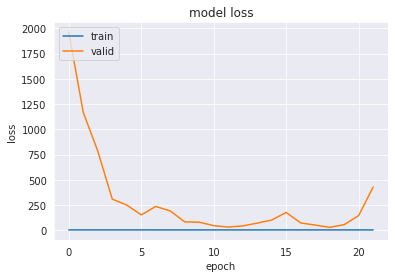

In [20]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

## Evaluate Interpretation Net

In [21]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [22]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

In [23]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,0.251,0.340,11.110,0.156,0.000,0.211,0.235,2.500,-77.428,3.192,6.545,0.102,0.183,-0.005,0.482,0.554
inetPoly_VS_targetPoly_test,0.257,0.350,8.799,0.151,0.000,0.218,0.241,3.099,-47.581,3.282,6.519,0.104,0.166,-0.034,0.476,0.548
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.210,0.232,2.505,-68.367,3.165,5.803,0.098,0.183,-0.005,0.482,0.550
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.217,0.239,3.100,-46.307,3.267,5.893,0.100,0.166,-0.034,0.476,0.544
inetPoly_VS_lstsqTarget_valid,0.812,1.074,35.814,0.068,0.000,0.405,0.445,2.326,-87.112,5.091,5.981,0.175,0.183,-0.084,0.482,0.093
inetPoly_VS_lstsqTarget_test,0.810,1.070,28.669,0.068,0.000,0.396,0.434,2.634,-86.087,5.254,5.176,0.168,0.166,-0.085,0.476,0.093
inetPoly_VS_lstsqLambda_valid,3.040,5.747,58.360,0.082,0.000,0.210,0.232,2.510,-68.350,3.165,5.806,0.098,0.183,-0.005,0.482,0.550
inetPoly_VS_lstsqLambda_test,3.080,5.807,64.805,0.079,0.000,0.217,0.239,3.101,-46.312,3.267,5.905,0.100,0.166,-0.034,0.476,0.544
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.003,0.003,0.165,0.999,0.017,0.053,0.003,-0.005,-0.005,0.550,0.550
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.003,0.003,0.382,0.999,0.017,0.052,0.003,-0.034,-0.034,0.544,0.544


In [24]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.122,0.395,0.142,0.157,0.088,0.222,0.123,0.300,0.199,0.143,0.043,0.211,0.198,0.088,0.138,0.387,0.082,0.257,0.236,0.143,0.204,0.218,0.048,0.164,0.270,0.320,0.247,0.230,0.188,0.376,0.280,0.200,0.200,0.098,0.142,0.296,0.180,0.285,0.194,0.126,0.104,0.171,0.193,0.199,0.217,0.153,0.130,0.331,0.290,0.388,0.277,0.366,0.241,0.213,0.262,0.111,0.163,0.292,0.559,0.107,0.444,0.201,0.209,0.179,0.247,0.279,0.260,0.058,0.208,0.233,0.059,0.115,0.155,0.138,0.161,0.060,0.250,0.308,0.179,0.115,0.235,0.229,0.126,0.245,0.262,0.289,0.250,0.206,0.273,0.128,0.093,0.101,0.285,0.205,0.117,0.149,0.100,0.221,0.204,0.176,0.187,0.146,0.160,0.155,0.191,0.261,0.109,0.241,0.261,0.227,0.056,0.123,0.155,0.316,0.292,0.187,0.251,0.321,0.153,0.174,0.035,0.216,0.143,0.199,0.515,0.279,0.225,0.230,0.194,0.247,0.208,0.408,0.264,0.470,0.223,0.363,0.303,0.148,0.204,0.138,0.154,0.149,0.234,0.230,0.158,0.252,0.224,0.198,0.331,0.428,0.073,0.240,0.190,0.236,0.260,0.179,0.421,0.238,0.165,0.018,0.272,0.240,0.143,0.253,0.203,0.300,0.198,0.245,0.274,0.272,0.645,0.163,0.034,0.135,0.227,0.195,0.242,0.313,0.193,0.

In [25]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.713,-5.539,-0.235,-35.144,0.307,-3.934,0.306,0.240,-56.525,0.171,0.598,0.333,-0.789,0.659,0.151,-8.870,0.774,0.060,-345.288,-0.351,0.273,0.394,0.880,0.496,-1.914,-0.003,-11.115,-140.676,0.533,0.185,0.124,-13.348,0.546,0.818,-0.446,-2.232,-5.239,-1.290,0.072,0.753,-0.001,0.802,-0.900,-17.630,0.382,-31.489,-0.632,-0.919,0.317,-0.240,-81.317,-1.670,-0.551,-65.031,-6.196,0.517,-2.030,0.217,-22.689,0.092,-64.648,0.219,0.082,-195.379,-0.147,-0.323,-1.445,0.880,-0.931,-0.867,0.531,-1.934,-0.274,0.725,-6.916,0.720,-0.272,0.261,-37.294,0.816,-4.986,-0.341,-2.116,0.325,-0.378,0.425,-128.845,-25.284,-236.093,-11.637,-0.425,-0.303,-0.675,-9.074,0.755,-0.532,0.798,0.597,0.551,-0.330,0.719,0.748,0.298,-5.070,-282.361,-0.462,-5.328,-2.108,0.149,-1.546,-0.101,-0.526,-37.409,0.357,0.362,-78.730,-199.284,0.262,-6.170,-0.552,0.834,-5.777,-3.406,-2.779,-41.924,0.315,0.687,0.271,-25.247,0.233,-235.724,-1.965,0.116,-42.746,-1367.039,0.102,-0.767,-3.850,-6.715,-0.411,-0.012,-2.063,-15.531,-84.007,0.272,-211.397,-139.333,-198.205,-170.922,-0.147,-0.228,-5.322,-1.779,-0.333,-2.731,-

In [26]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-0.24202953085291434


<IPython.core.display.Math object>

In [27]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda)

-95.52159475690425


<IPython.core.display.Math object>

In [28]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [29]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

-30.720134241566917


<IPython.core.display.Math object>

In [30]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda)

0.9460843662688037


<IPython.core.display.Math object>

In [31]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target)

<IPython.core.display.Math object>

In [32]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -47.581307072371196 (1000 Samples)
Mean (only positive): 0.445398640379157 (288 Samples)


In [33]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.6312122195142127 (1000 Samples)
Mean (only positive): 0.9482799593954079 (974 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

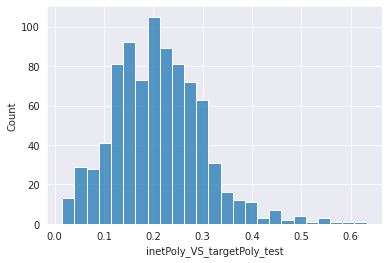

In [34]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

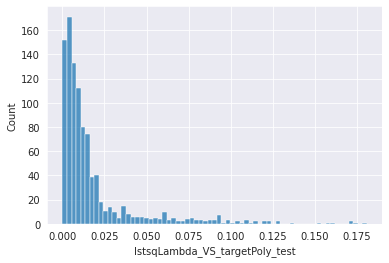

In [35]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

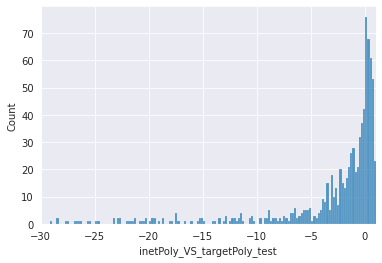

In [36]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

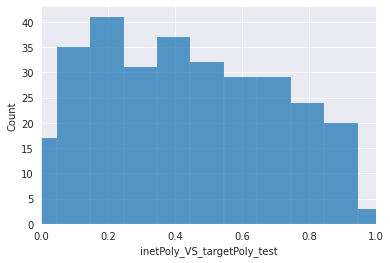

In [37]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

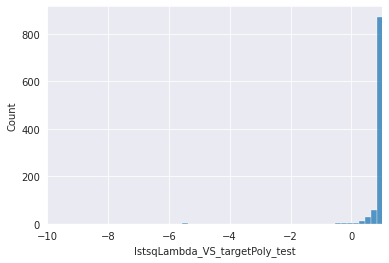

In [38]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

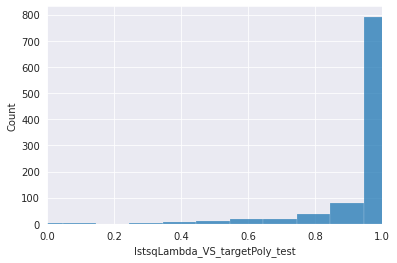

In [39]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

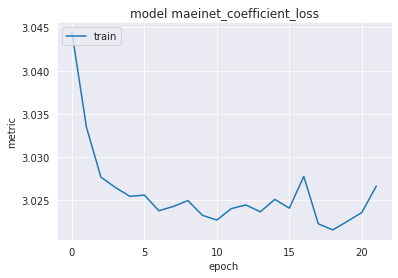

In [40]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


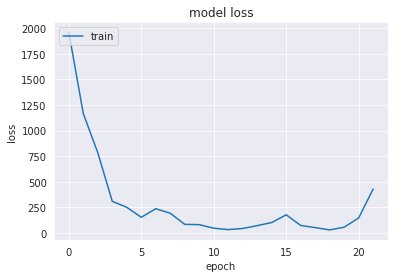

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

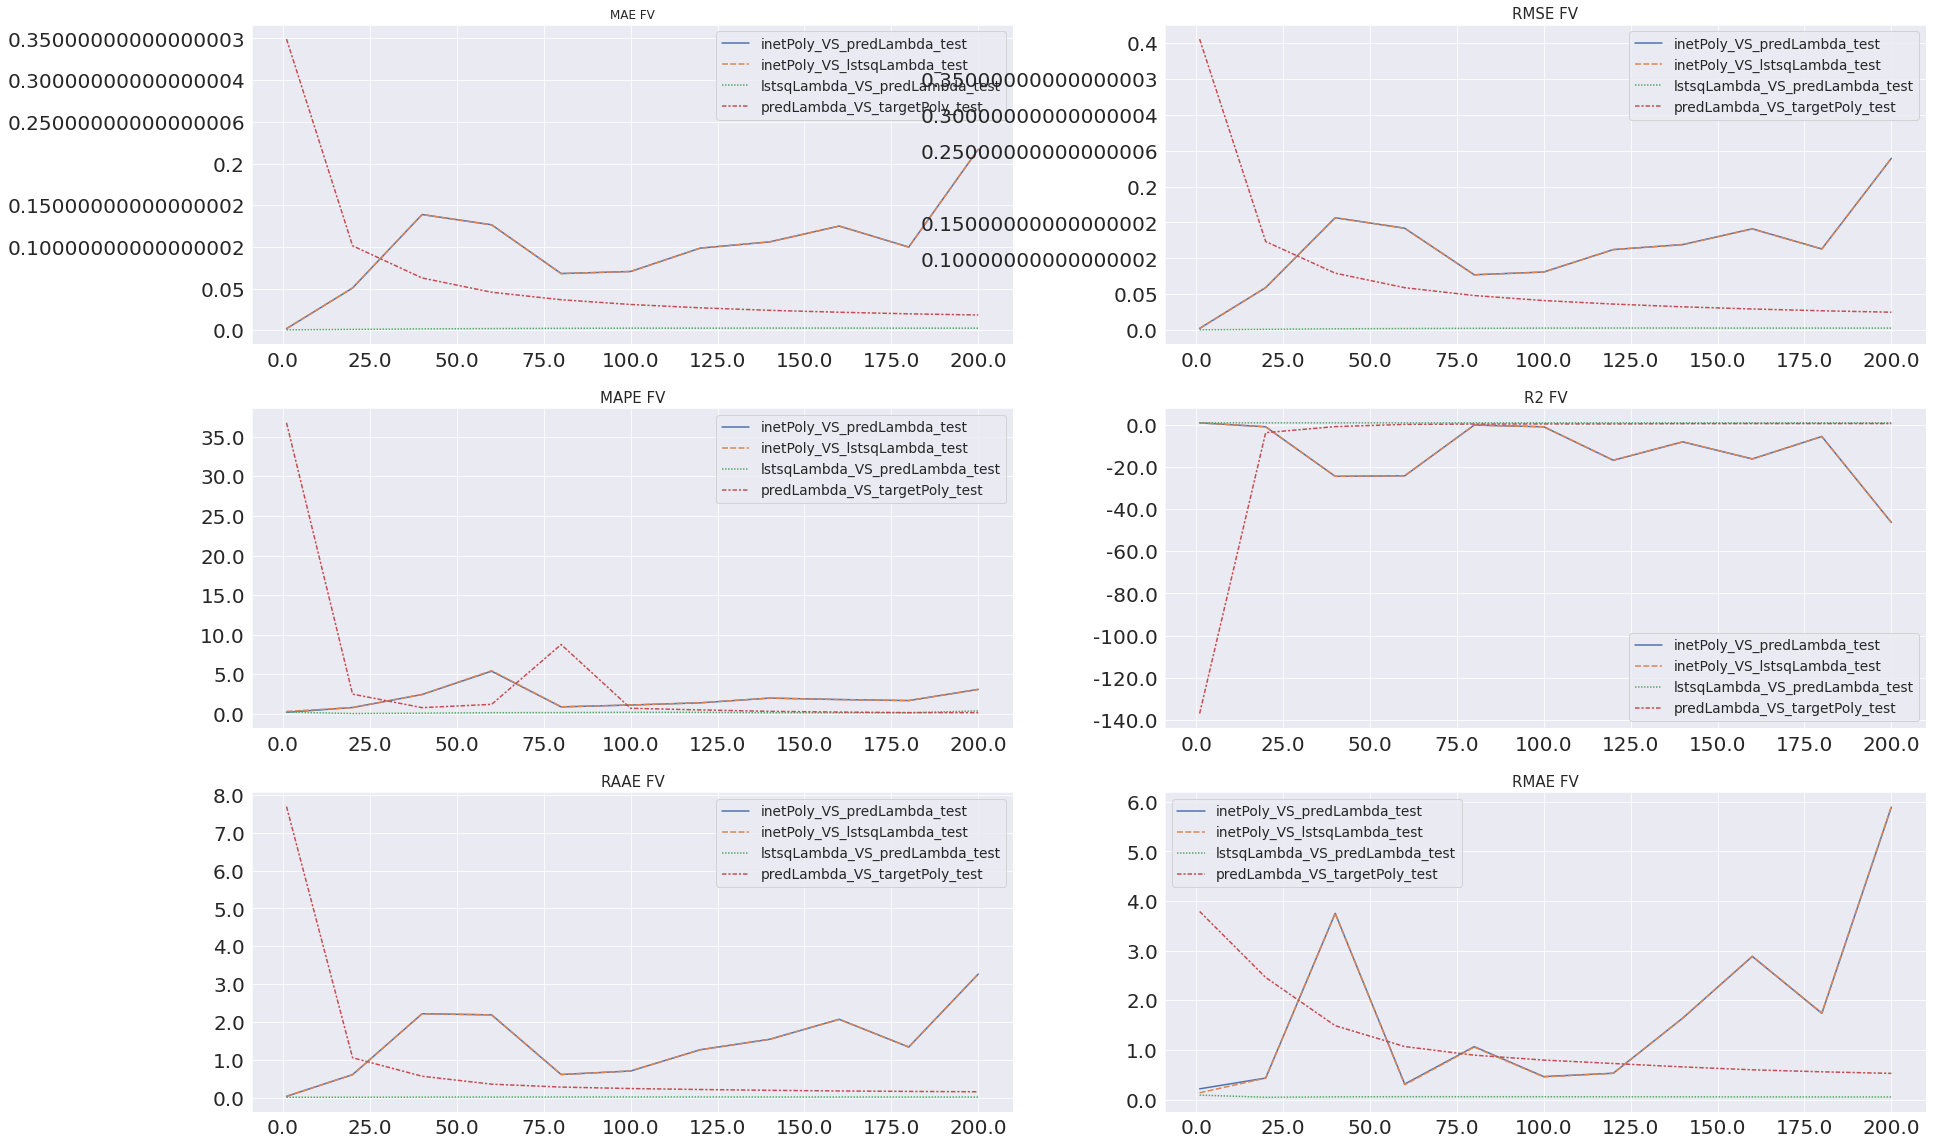

In [42]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

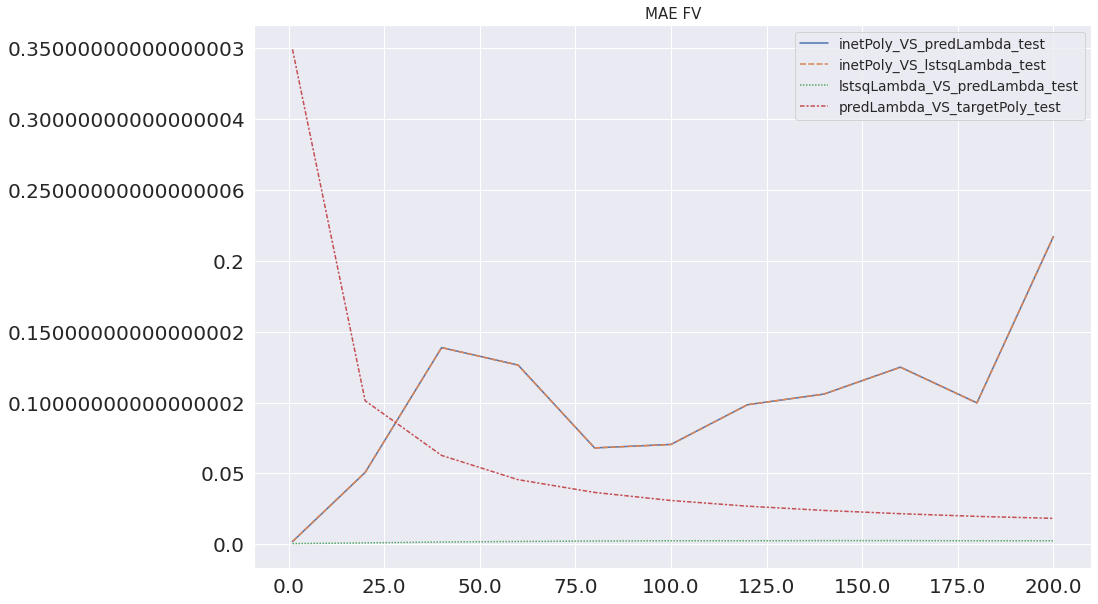

In [43]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

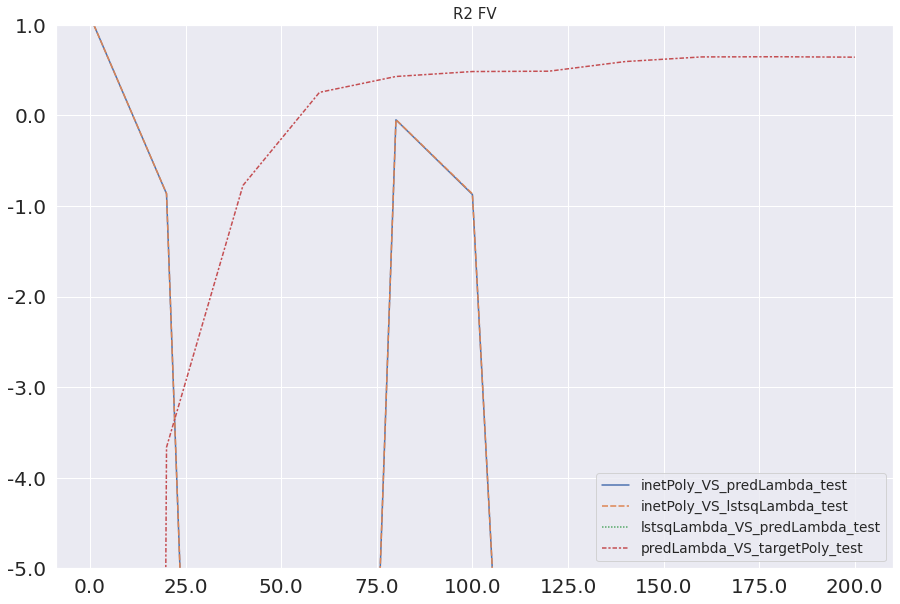

In [44]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [45]:
index = 43

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet)


Target Poly:


<IPython.core.display.Math object>

LSTSQ Target Poly:


<IPython.core.display.Math object>

LSTSQ Lambda Poly:


<IPython.core.display.Math object>

I-Net Poly:


<IPython.core.display.Math object>

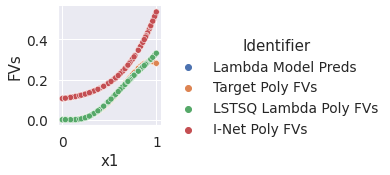

In [46]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=index, 
                                                      plot_type=1)

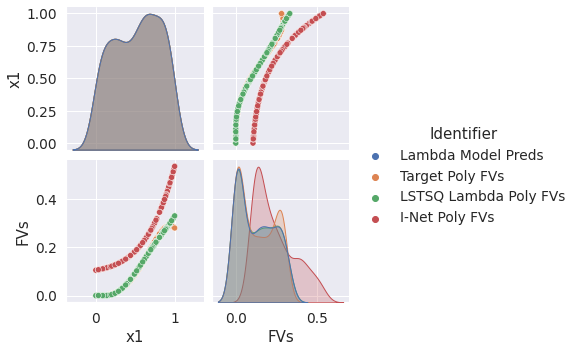

In [47]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=index, 
                                                      plot_type=2)

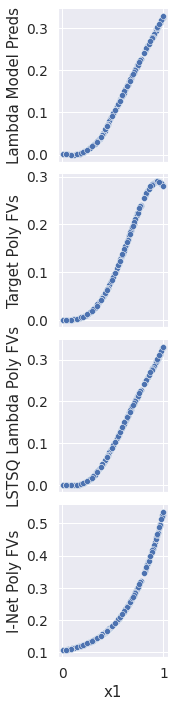

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [49]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [50]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list)

In [51]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0263


In [52]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 6.3416


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [53]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [54]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.3998


In [55]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [56]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()